In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import time
from torchsummary import summary
import copy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,0.1307,0.1307), (0.3081,0.3081,0.3081))  # Normalize to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
print(test_dataset.classes)
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

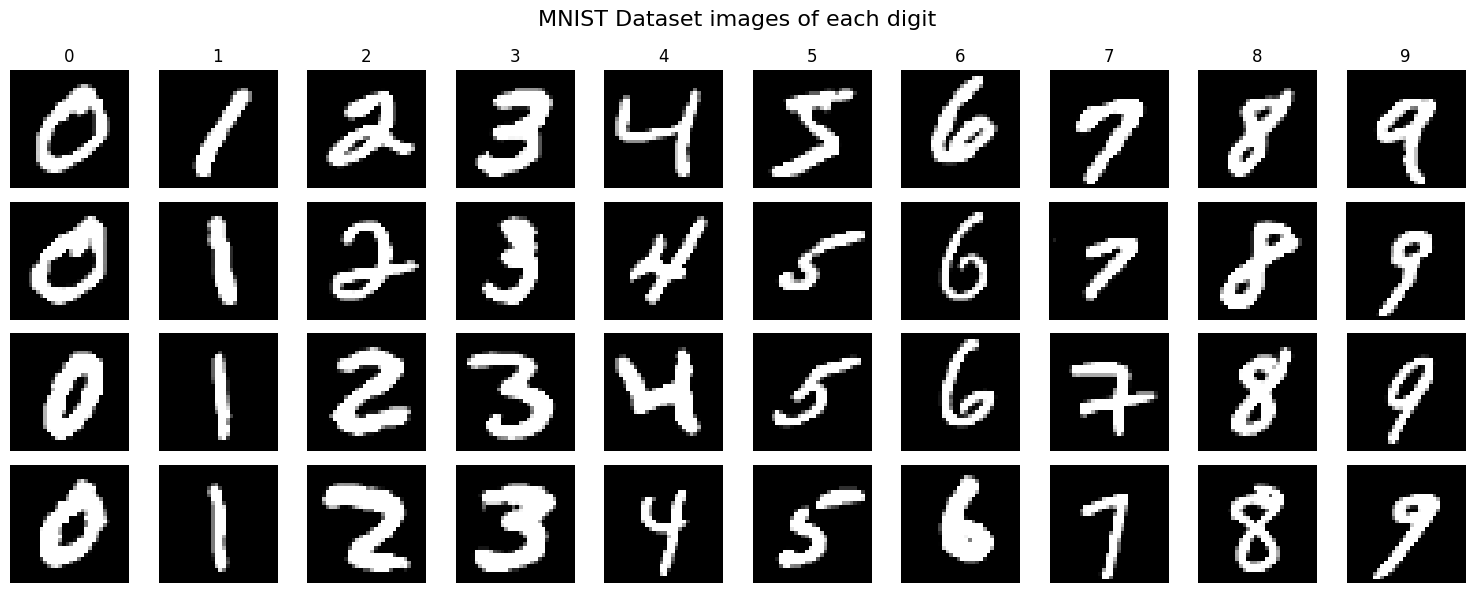

In [4]:
selected_images = {i: 0 for i in range(10)}
mnist_samples = {i: [] for i in range(10)}

# Collect 4 images per category
for img, label in train_dataset:
    if selected_images[label] < 4:
        mnist_samples[label].append(img.numpy())  # Remove the channel dimension
        selected_images[label] += 1
    if all(count == 4 for count in selected_images.values()):
        break

# Create a figure for the MNIST images
fig, axes = plt.subplots(4, 10, figsize=(15, 6))
fig.suptitle("MNIST Dataset images of each digit", fontsize=16)

# Plot the images column-wise with labels on top
for col, (label, images) in enumerate(mnist_samples.items()):
    for row, img in enumerate(images):
        ax = axes[row, col]
        #print(img.shape)
        ax.imshow(np.transpose(img, (1, 2, 0)))
        #print(np.transpose(img, (1, 2, 0)).shape) 
        ax.axis("off")
    axes[0, col].set_title(str(label), fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig(f"dataset mnist.png",dpi=256)
plt.show()

In [5]:
device=(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(device)
#model=models.vgg16(pretrained=False)
#model.cuda()
#summary(model,(3,32,32))
dict_Tloss = {}
dict_Vloss= {}
dict_Tt={}
dict_Ta={}
dict_Va={}

dict_Sd={} #state dictionary of model for each opt for min val loss resprctively

cuda


In [6]:
print(len(test_loader))
print(len(train_loader))
print(len(train_dataset))
print(len(test_dataset))

157
469
60000
10000


In [7]:
def get_optimizer(optimizer_name, model):
    if optimizer_name == 'mBGD':
        return optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == 'Momentum':
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == 'NAG':
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
    elif optimizer_name == 'Adagrad':
        return optim.Adagrad(model.parameters(), lr=0.01)
    elif optimizer_name == 'RMSProp':
        return optim.RMSprop(model.parameters(), lr=0.01)
    elif optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=0.01)
    else:
        raise ValueError("Unsupported optimizer!")


Training with Adam optimizer:


C:\Users\ozair\anaconda3\envs\vpytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ozair\anaconda3\envs\vpytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/8, Loss: 0.3213, Accuracy: 91.23%
Epoch 1/8, Loss: 0.3213, Train Accuracy: 91.23% Val Accuracy: 96.49%
              precision    recall  f1-score   support

    0 - zero      0.971     0.968     0.970       980
     1 - one      0.995     0.934     0.964      1135
     2 - two      0.951     0.987     0.969      1032
   3 - three      0.988     0.943     0.965      1010
    4 - four      0.979     0.958     0.969       982
    5 - five      0.989     0.970     0.979       892
     6 - six      0.958     0.993     0.975       958
   7 - seven      0.987     0.955     0.971      1028
   8 - eight      0.894     0.989     0.939       974
    9 - nine      0.946     0.958     0.952      1009

    accuracy                          0.965     10000
   macro avg      0.966     0.966     0.965     10000
weighted avg      0.966     0.965     0.965     10000

Epoch 2/8, Loss: 0.1150, Accuracy: 97.09%
Epoch 2/8, Loss: 0.1150, Train Accuracy: 97.09% Val Accuracy: 98.35%
              preci

KeyboardInterrupt: 

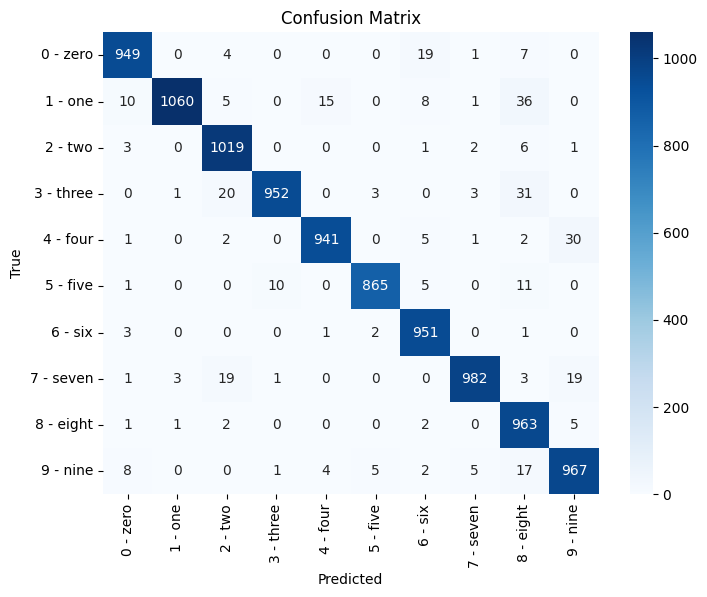

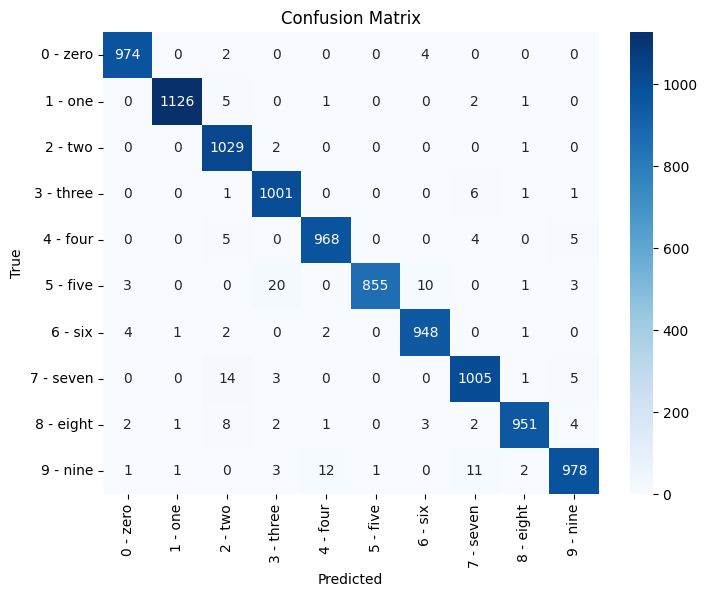

In [13]:
epochs=8
optimizers = ['Adam']#'minibatch_sgd', 'sgd_momentum','NAG', 'adagrad','rmsprop',
for opt_name in optimizers:
    print(f"\nTraining with {opt_name} optimizer:")
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #model = models.resnet18(pretrained=False)  # Reinitialize the model
    #model.fc = nn.Linear(model.fc.in_features, 10)
    #model= models.googlenet(pretrained=False,aux_logits=False)
    #model.fc = nn.Linear(model.fc.in_features, 10)
    model = models.mobilenet_v2(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
    model = model.to(device)
    
    #best_M=copy.deepcopy(model.state_dict())
    best_A=0.0
    
    optimizer = get_optimizer(opt_name, model)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    #model.train()
    tt=[]
    losses = []
    vlosses=[]
    ta=[]
    va=[]
    for epoch in range(epochs):
        #total_loss = 0
        correct = 0
        val_correct=0
        epoch_loss = 0
        epoch_val_loss=0
        epoch_start_time = time.time()
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

        epoch_time = time.time() - epoch_start_time
        #print(epoch_time)
        tt.append(epoch_time)
        losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}, "
              f"Accuracy: {100 * correct/len(train_dataset):.2f}%")
        all_predictions = []
        all_labels = []
        model.eval()  
        with torch.no_grad():
            for val_X, val_y in test_loader:
                val_X, val_y  = val_X.to(device), val_y.to(device)
                val_predictions = model(val_X)
                val_loss = criterion(val_predictions, val_y)
                epoch_val_loss += val_loss.item()
                _, predicted = torch.max(val_predictions, 1)
                val_correct += (predicted == val_y).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(val_y.cpu().numpy())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {100 * correct/len(train_dataset):.2f}% Val Accuracy: {100 * val_correct/len(test_dataset):.2f}%")
        temp_A=val_correct/len(test_dataset)
        ta.append(correct/len(train_dataset))
        va.append(temp_A)
        vlosses.append(epoch_val_loss / len(test_loader))
        if temp_A>best_A:
            best_A=temp_A
            #best_M=copy.deepcopy(model.state_dict())
            conf_matrix = confusion_matrix(all_labels, all_predictions)
            class_names = test_dataset.classes
            class_report = classification_report(all_labels, all_predictions, target_names=class_names, digits=3)
            print(class_report)
            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix')
            #plt.show()
            plt.savefig(f'confusion Matrix {opt_name}.png',dpi=500)
            with open("Classification Report.txt",'wt') as f:
                f.write(class_report)
    dict_Tloss[opt_name] = losses
    dict_Vloss[opt_name] = vlosses
    dict_Tt[opt_name]=tt
    dict_Ta[opt_name]=ta
    dict_Va[opt_name]=va
    #dict_Sd[opt_name]=best_M
    

In [104]:
print(dict_Tloss,dict_Vloss,dict_Tt)

{'Adam': [0.32134554009320637, 0.11502104241456558, 0.10434260487363839, 0.07462088800649018, 0.06731533365838452, 0.06670194874549391, 0.06646363886504142, 0.06721526226684102]} {'Adam': [0.13363623233908004, 0.06545453883891415, 0.0710065427813145, 0.045092525672476, 0.06584148922276863, 0.07347055313705354, 0.04501494515340947, 0.07986586981424824]} {'Adam': [83.90586495399475, 84.32336354255676, 84.44598722457886, 85.10791540145874, 84.60729265213013, 84.58468985557556, 84.78096079826355, 86.12611889839172]}


In [105]:
print(dict_Tloss,dict_Vloss,dict_Tt,dict_Ta,dict_Va)

{'Adam': [0.32134554009320637, 0.11502104241456558, 0.10434260487363839, 0.07462088800649018, 0.06731533365838452, 0.06670194874549391, 0.06646363886504142, 0.06721526226684102]} {'Adam': [0.13363623233908004, 0.06545453883891415, 0.0710065427813145, 0.045092525672476, 0.06584148922276863, 0.07347055313705354, 0.04501494515340947, 0.07986586981424824]} {'Adam': [83.90586495399475, 84.32336354255676, 84.44598722457886, 85.10791540145874, 84.60729265213013, 84.58468985557556, 84.78096079826355, 86.12611889839172]} {'Adam': [0.9122666666666667, 0.9709166666666667, 0.9736, 0.9809166666666667, 0.9826166666666667, 0.9836, 0.9835, 0.9827833333333333]} {'Adam': [0.9649, 0.9835, 0.9805, 0.9888, 0.9829, 0.9802, 0.9898, 0.9806]}


In [ ]:
for name in dict_Tt:
    print(f"optimizer: {name} total training time: {sum(dict_Tt[name]):.3f}sec average time per epoch: {sum(dict_Tt[name])/n_epochs:.3f}sec min train loss: {min(dict_Tloss[name]):.3f} min val loss: {min(dict_Vloss[name]):.3f}")

In [106]:
a=[]
for i in range(1,epochs+1,1):
    a.append(i)

print(a)

[1, 2, 3, 4, 5, 6, 7, 8]


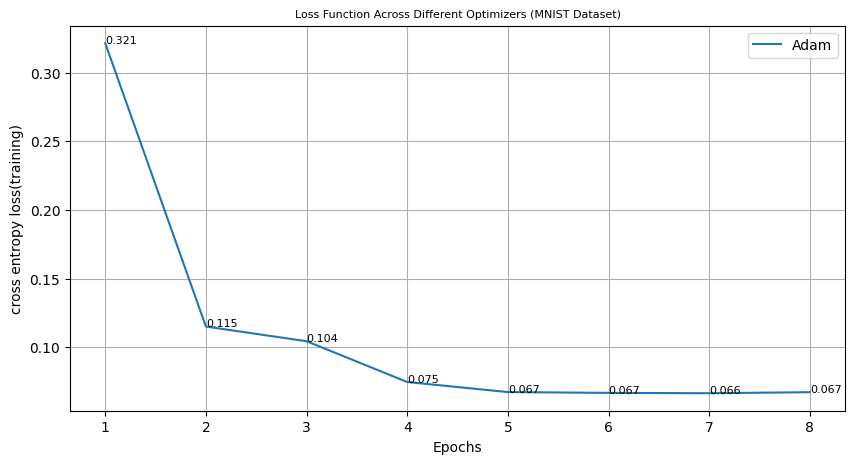

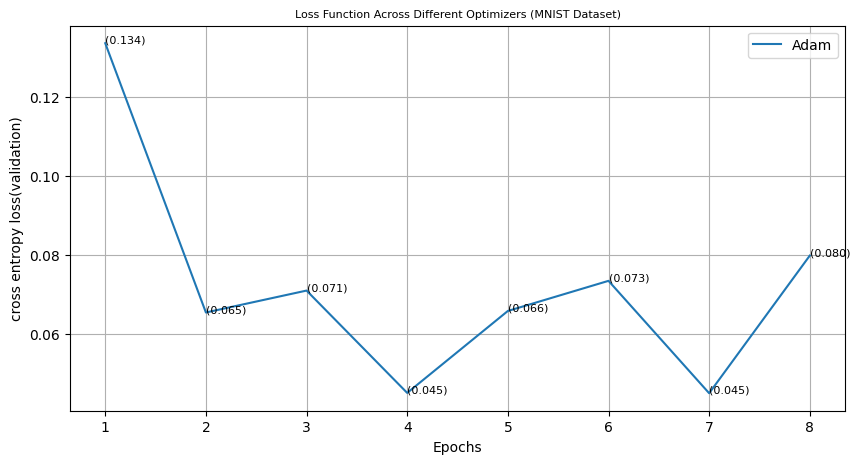

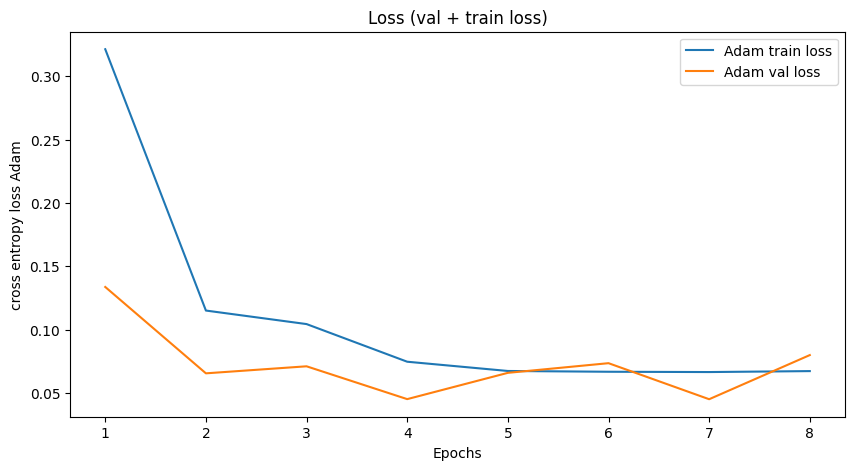

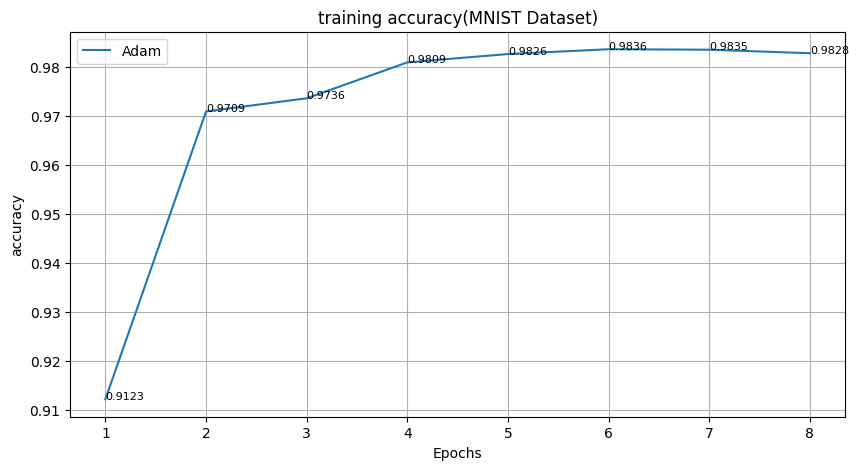

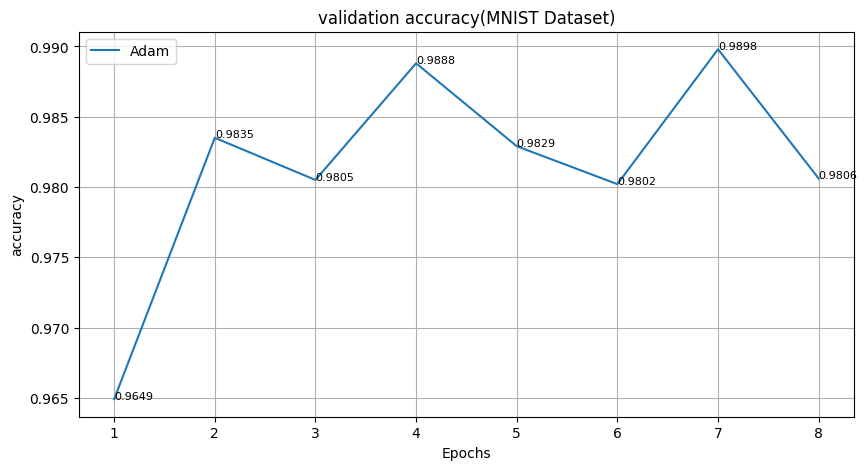

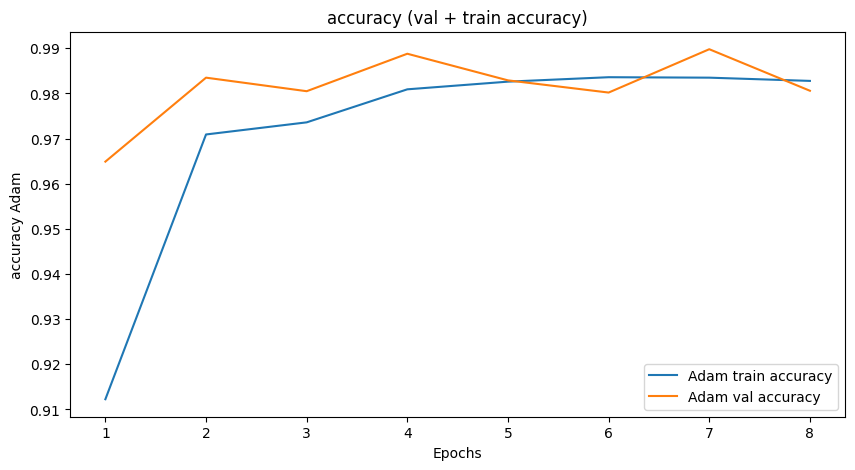

In [115]:
#plot train loss only individual
for name, loss in dict_Tloss.items():
    plt.figure(figsize=(10, 5))
    plt.title('Loss Function Across Different Optimizers (MNIST Dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel('cross entropy loss(training)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
    for c, d in zip(a, loss):
        plt.annotate(text=f"{d:.3f}",xy=(c, d),fontsize=8)
    #plt.savefig(f'Training loss {name}.png',dpi=500)
    plt.show()
#plt.savefig(f'combined training loss all.png',dpi=500)
#plt.show()

#plot validation loss only individual
for name, loss in dict_Vloss.items():
    plt.figure(figsize=(10, 5))
    plt.title('Loss Function Across Different Optimizers (MNIST Dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel(f'cross entropy loss(validation)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
    for c, d in zip(a, loss):
        plt.annotate(text=f"({d:.3f})",xy=(c, d),fontsize=8)
    #plt.savefig(f'validation loss {name}.png',dpi=500)
    plt.show()
#plt.savefig(f'combined validation loss all.png',dpi=500)
#plt.show()


#plot train and validation loss together for each opt individually
for name, loss in dict_Vloss.items():
    plt.figure(figsize=(10, 5))
    plt.title('Loss (val + train loss)')
    plt.xlabel('Epochs')
    plt.ylabel(f'cross entropy loss {name}')
    plt.plot(a,dict_Tloss[name],label=name+' train loss')
    plt.plot(a,dict_Vloss[name],label=name+" val loss")
    plt.legend()
    #plt.savefig(f'combined train and val {name}.png',dpi=500)
    plt.show()
    
#plot train accuracy individual
for name, loss in dict_Ta.items():
    plt.figure(figsize=(10, 5))
    plt.title('training accuracy(MNIST Dataset)')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
    for c, d in zip(a, loss):
        plt.annotate(text=f"{d:.4f}",xy=(c, d),fontsize=8)
    #plt.savefig(f'Training accuracy {name}.png',dpi=500)
    plt.show()

#plot validation accuracy individual
for name, loss in dict_Va.items():
    plt.figure(figsize=(10, 5))
    plt.title('validation accuracy(MNIST Dataset)')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
    for c, d in zip(a, loss):
        plt.annotate(text=f"{d:.4f}",xy=(c, d),fontsize=8)
    #plt.savefig(f'validation accuracy {name}.png',dpi=500)
    plt.show()

#plot train and validation accuracy together for each opt individually
for name, loss in dict_Vloss.items():
    plt.figure(figsize=(10, 5))
    plt.title('accuracy (val + train accuracy)')
    plt.xlabel('Epochs')
    plt.ylabel(f'accuracy {name}')
    plt.plot(a,dict_Ta[name],label=name+' train accuracy')
    plt.plot(a,dict_Va[name],label=name+" val accuracy")
    plt.legend()
    #plt.savefig(f'combined train and val accuracy {name}.png',dpi=500)
    plt.show()

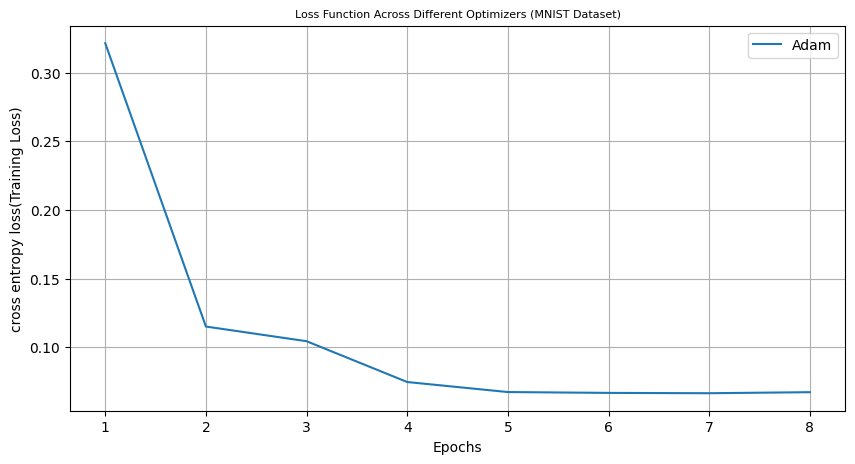

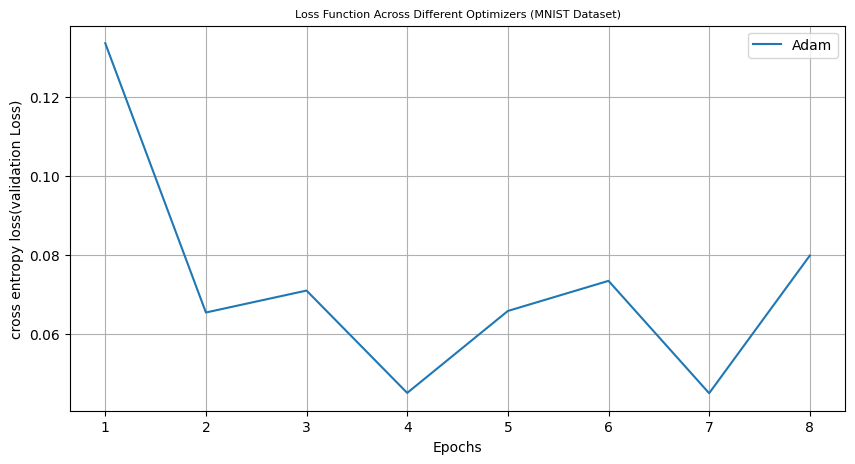

In [112]:
#plot train loss of all optimizers
plt.figure(figsize=(10, 5))
for name, loss in dict_Tloss.items():
    plt.title('Loss Function Across Different Optimizers (MNIST Dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel('cross entropy loss(Training Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
#plt.savefig(f'combined training loss all.png',dpi=500)
plt.show()

#plot val loss of all optimizers
plt.figure(figsize=(10, 5))
for name, loss in dict_Vloss.items():
    plt.title('Loss Function Across Different Optimizers (MNIST Dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel(f'cross entropy loss(validation Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
#plt.savefig(f'combined validation loss all.png',dpi=500)
plt.show()

#plot train accuracy combined
for name, loss in dict_Ta.items():
    plt.figure(figsize=(10, 5))
    plt.title('training accuracy(MNIST Dataset)')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
    for c, d in zip(a, loss):
        plt.annotate(text=f"{d:.4f}",xy=(c, d),fontsize=8)   
#plt.savefig(f'combined Training accuracy.png',dpi=500)
plt.show()
#plot validation accuracy combined
for name, loss in dict_Va.items():
    plt.figure(figsize=(10, 5))
    plt.title('validation accuracy(MNIST Dataset)')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
#plt.savefig(f'combined validation accuracy.png',dpi=500)
plt.show()

In [ ]:
geeky_file = open('TrainingResults.txt', 'wt') 
geeky_file.write("train loss\n "+str(dict_Tloss)+"\nvalidation loss\n "+str(dict_Vloss)+"\n Training time\n "+str(dict_Tt)+"\nTraining accuracy\n "+str(dict_Ta)+"\nvalidation accuracy\n "+str(dict_Va)) 
geeky_file.close()

In [ ]:
#optional
#save all state dictionaries
for name, sd in dict_Sd.items():
    target = f'./statedictionary/{name}_resnet18.pth'
    torch.save(sd, target)